<a href="https://colab.research.google.com/github/Witcape/Emotion_Recognition_in_Live_Video_Data/blob/main/Emotion_Recognition_in_Video_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1 - Import all the Libraries and google drive

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sklearn
import tensorflow as tf
import pandas as pd
import sklearn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.activations import linear,relu,sigmoid
import cv2
import os
import PIL
import pathlib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.preprocessing import image
import tensorflow_datasets as tfds

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Step 2 - Loading Data & Preprocessing

In [3]:
train_data_dir = '/content/gdrive/MyDrive/Human emotions/train'
test_data_dir = '/content/gdrive/MyDrive/Human emotions/test'

In [4]:
picture_size = 48
batch_size = 32
no_of_classes = 7
epochs = 20

datagen_train = ImageDataGenerator (
                                    rescale=1./255,
                                    validation_split=0.2
                                    )

datagen_val   = ImageDataGenerator (
                                    rescale=1./255
                                    )
datagen_test   = ImageDataGenerator (
                                    rescale=1./255
                                    )

In [5]:
train_set = datagen_train.flow_from_directory(
    train_data_dir,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    test_data_dir,

    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 29031 images belonging to 7 classes.
Found 7378 images belonging to 7 classes.


## Step 3 - Model

In [6]:
model = Sequential(
    [
        Conv2D(128, (3,3), 1,  activation = 'relu', padding='same', input_shape = (picture_size, picture_size, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        BatchNormalization(),

        Conv2D(256, (3,3), 1,  activation = 'relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(512, (3,3), 1,  activation = 'relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(256, (3,3), 1,  activation = 'relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(128, (3,3), 1,  activation = 'relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Flatten(),

        Dense(512, activation = 'relu'),
        Dense(7, activation = 'softmax')
    ]
)

In [7]:
# model.compile(
#     optimizer = Adam(learning_rate = 0.01),
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [8]:
# model.summary()

In [9]:
# log_dir = '/content/gdrive/MyDrive/Human emotions/Logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [10]:
# early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss', min_lr=0.00001)

In [11]:
# history = model.fit(
#     train_set,
#     epochs=2,
#     validation_data=val_set,
#     callbacks=[early_stopping, reduce_lr]
# )

In [12]:
loaded_model = load_model('/content/gdrive/MyDrive/Human emotions/val_acc_61', compile=False)

loaded_model.compile(optimizer=Adam(learning_rate=0.01), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
# predictions = loaded_model.predict(val_set)

In [14]:
# predicted_classes = np.argmax(predictions, axis=1)

In [15]:
# accuracy = loaded_model.evaluate(val_set)[1]

In [58]:
def image_test(image_path):
  image = cv2.imread(image_path)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (48, 48))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  return img, img_array

In [59]:
image_path = '/content/Photo on 8-11-23 at 10.40 PM.jpg'
img, img_array = image_test(image_path)

In [60]:
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_emotion = emotion_labels[predicted_class]
predicted_emotion

1/1 [==============================] - 0s 67ms/step


'Sad'

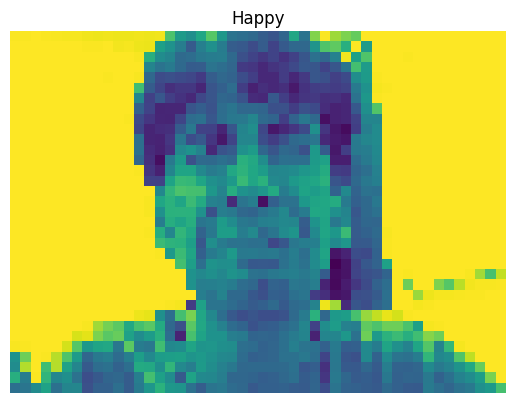

In [57]:
plt.imshow(img)
plt.title(predicted_emotion)
plt.axis('off')
plt.show()

## Trying to make it work with video frames